In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
# Paths
dataset_path = "handwriting"  # Replace with your dataset folder path
categories = ["High risk for Dysgraphia", "Low risk for Dysgraphia"]

In [4]:
# Image preprocessing parameters
img_width, img_height = 150, 150  # Resize all images
data = []
labels = []

In [5]:
# Function to segment words in an image
def segment_words(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_segments = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter small noise
        if w > 20 and h > 20:  # Adjust thresholds as needed
            word = image[y:y+h, x:x+w]
            word_segments.append(word)
    return word_segments

In [6]:
# Read and label the images
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = categories.index(category) 

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            # Read image
            img = cv2.imread(img_path)
            # Segment the words in the image
            word_segments = segment_words(img)

            for word in word_segments:
                # Resize each segmented word to fit model input shape
                word_resized = cv2.resize(word, (img_width, img_height))
                
                # Convert to grayscale and normalize
                word_gray = cv2.cvtColor(word_resized, cv2.COLOR_BGR2GRAY)
                word_normalized = word_gray / 255.0
                
                # Reshape for CNN (150x150x1)
                word_normalized = np.expand_dims(word_normalized, axis=-1)

                # Append the data and labels
                data.append(word_normalized)
                labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

In [7]:
# Convert to numpy arrays
data = np.array(data, dtype="float32")  # No need to divide again here, it's already done
labels = np.array(labels)

In [8]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),  # Shape: (150, 150, 1)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Train the model
epochs = 10
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.6667 - loss: 0.6039 - val_accuracy: 0.8177 - val_loss: 0.3395
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.8732 - loss: 0.3248 - val_accuracy: 0.8840 - val_loss: 0.2921
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.8998 - loss: 0.2354 - val_accuracy: 0.9116 - val_loss: 0.2549
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.9428 - loss: 0.1494 - val_accuracy: 0.9171 - val_loss: 0.2930
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9752 - loss: 0.1007 - val_accuracy: 0.8619 - val_loss: 0.3988
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.9789 - loss: 0.0888 - val_accuracy: 0.8287 - val_loss: 0.5256
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.9738 - loss: 0.0749 - val_accuracy: 0.8840 - val_loss: 0.3895
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.9879 - loss: 0.0417 - val_accuracy: 

In [12]:
# Save the model
model.save("handwriting_dysgraphia_model.h5")

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8905 - loss: 0.7893
Validation Loss: 0.697682797908783
Validation Accuracy: 0.889502763748169


C:\Users\acer\AppData\Local\Temp\ipykernel_12164\3365053882.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=category_counts, palette="viridis")


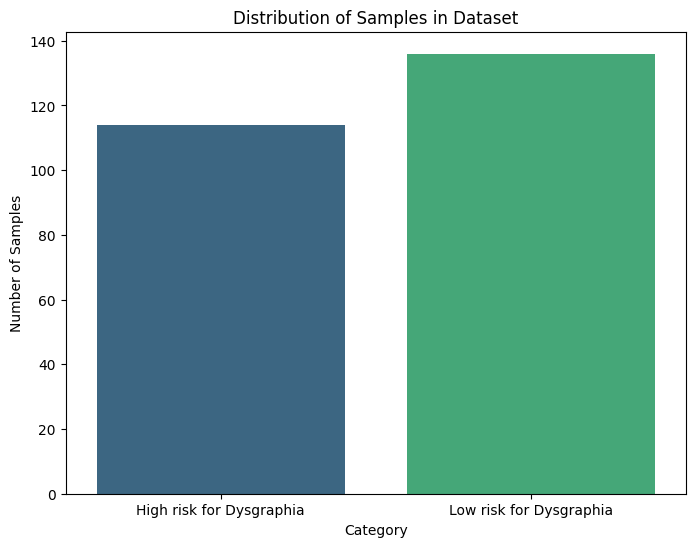

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Data distribution visualization
category_counts = [len(os.listdir(os.path.join(dataset_path, category))) for category in categories]
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=category_counts, palette="viridis")
plt.title("Distribution of Samples in Dataset")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.show()

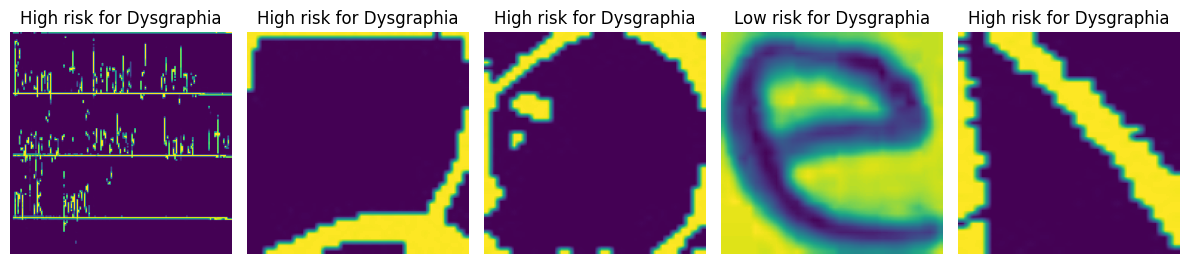

In [15]:
# Display random sample images
def show_random_samples(data, labels, category_names, num_samples=5):
    plt.figure(figsize=(12, 8))
    indices = random.sample(range(len(data)), num_samples)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[idx])
        plt.title(category_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display random images from each class
show_random_samples(data, labels, categories, num_samples=5)

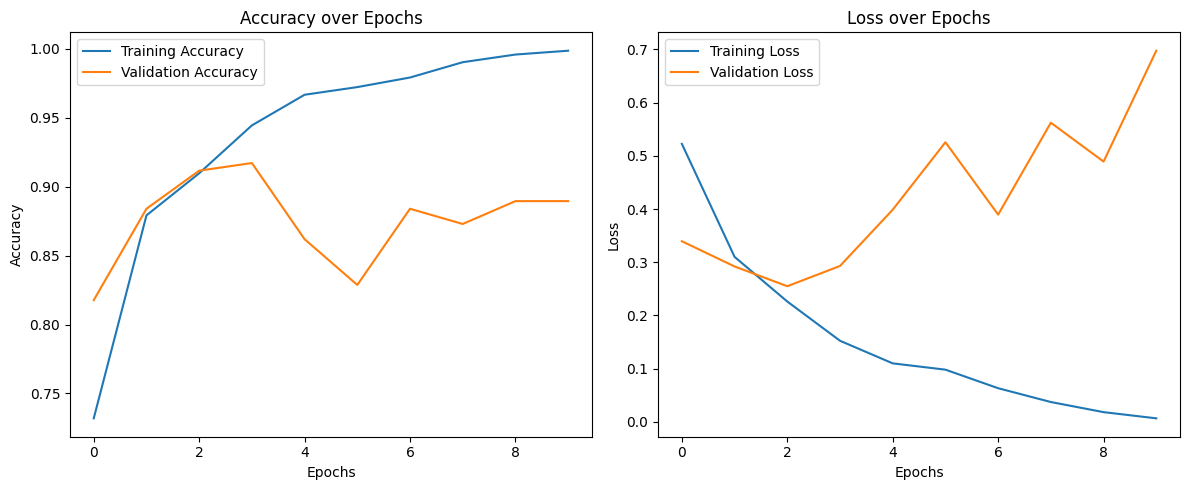

In [16]:
# Training and validation accuracy/loss plots
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [17]:
# Save the model
model.save("handwriting_dysgraphia_model.h5")
print("Model saved as handwriting_dysgraphia_model.h5")


Model saved as handwriting_dysgraphia_model.h5
